In [20]:
# bacend.ai
# !pip install prophet
# !pip install plotnine

# import

In [45]:
import numpy as np 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
# import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io

import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error


# import sys
# sys.path.append("../Import")
# from definitions import crop_list3
# crop_list3 = [
#     ("마늘", "garlic"),
#     ("깻잎", "sesameLeaf"),
#     ("감자", "potato"),
#     ("고구마", "sweetPotato"),
# ]
root_path = "../"
data_path = f"{root_path}data/"
# 마늘
Product = "감자"
Product_eng = "potato"
# Product = crop_list3[0][0]
# Product_eng = crop_list3[0][1]


params_search = False
# for report file
model_name = "prophet"
freq = "M"
test_year = (2019, 2020)
train_year = (2010, 2018)

# Data road

In [22]:
df_raw = pd.read_csv(f'{data_path}Agri_all.csv')
df = df_raw[df_raw['Product'] == Product]
df.head()

,YMD,YM,MD,Product,Price,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
7940,2005-01-03,200501,103,감자,6323.101449,1013.0,3.33,71.15,69.162,65.4,60.5,4.50,6.75,47.75,1.0,3.75,0.25,0.0
7941,2005-01-04,200501,104,감자,6233.314286,1013.0,3.33,71.15,69.162,65.4,60.5,-2.25,8.00,36.25,0.0,3.00,3.50,0.0
7942,2005-01-05,200501,105,감자,6332.028169,1013.0,3.33,71.15,69.162,65.4,60.5,-3.50,11.50,44.75,0.0,0.50,4.25,0.0
7943,2005-01-06,200501,106,감자,6417.352113,1013.0,3.33,71.15,69.162,65.4,60.5,1.50,7.00,45.25,1.5,1.50,2.25,0.0
7944,2005-01-07,200501,107,감자,6581.362319,1013.0,3.33,71.15,69.162,65.4,60.5,0.25,9.25,38.75,0.0,3.00,4.00,0.0


# Data Pre-processing

## idx, col

In [23]:
# col
df.rename(columns = {'YMD' : 'ds', 'Price' : 'y'}, inplace=True)
# idx
df = df.reset_index()
df = df.drop(columns='index')
df.head()

,ds,YM,MD,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count
0,2005-01-03,200501,103,감자,6323.101449,1013.0,3.33,71.15,69.162,65.4,60.5,4.50,6.75,47.75,1.0,3.75,0.25,0.0
1,2005-01-04,200501,104,감자,6233.314286,1013.0,3.33,71.15,69.162,65.4,60.5,-2.25,8.00,36.25,0.0,3.00,3.50,0.0
2,2005-01-05,200501,105,감자,6332.028169,1013.0,3.33,71.15,69.162,65.4,60.5,-3.50,11.50,44.75,0.0,0.50,4.25,0.0
3,2005-01-06,200501,106,감자,6417.352113,1013.0,3.33,71.15,69.162,65.4,60.5,1.50,7.00,45.25,1.5,1.50,2.25,0.0
4,2005-01-07,200501,107,감자,6581.362319,1013.0,3.33,71.15,69.162,65.4,60.5,0.25,9.25,38.75,0.0,3.00,4.00,0.0


## 날짜를 'ds' 컬럼으로 설정.

In [24]:
if freq == "D":
    start_date = pd.to_datetime(f'{train_year[0]}-01-01')
    end_date = pd.to_datetime(f'{test_year[1]}-12-31')    
elif freq == "M":
    start_date = pd.to_datetime(f'{train_year[0]}-01')
    end_date = pd.to_datetime(f'{test_year[1]}-12')

dates = pd.date_range(start_date,end_date,freq=freq)
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0 : 'ds'})
dates

,ds
0,2010-01-31
1,2010-02-28
2,2010-03-31
3,2010-04-30
4,2010-05-31
...,...
126,2020-07-31
127,2020-08-31
128,2020-09-30
129,2020-10-31


In [25]:
df['ds'] = pd.to_datetime(df['ds'])
df['ds']

0      2005-01-03
1      2005-01-04
2      2005-01-05
3      2005-01-06
4      2005-01-07
          ...    
3965   2020-12-24
3966   2020-12-28
3967   2020-12-29
3968   2020-12-30
3969   2020-12-31
Name: ds, Length: 3970, dtype: datetime64[ns]

## EDA

In [46]:
def _fig_plot(
    df,
    X,
    Y,
    Figsize=(12, 6),
    Label=f"{Product_eng} price",
    xAxisLabel=f"Time ({freq})",
    yAxisLabel="Price",
    Title=f"{Product_eng} Price",
):
    """
    Function plots the data. requires to provide dataframe in the
    format of date as ds, observation as y, Preset other variables e.g., axis name
    """
    df.plot(x=X, y=Y, figsize=Figsize, label=Label)
    plt.xlabel(xAxisLabel, fontsize=16)  # matplotlib.pyplot
    plt.ylabel(yAxisLabel, fontsize=16)
    plt.legend()
    plt.title(Title, fontsize=20)
    ax = plt.gca().get_xaxis()

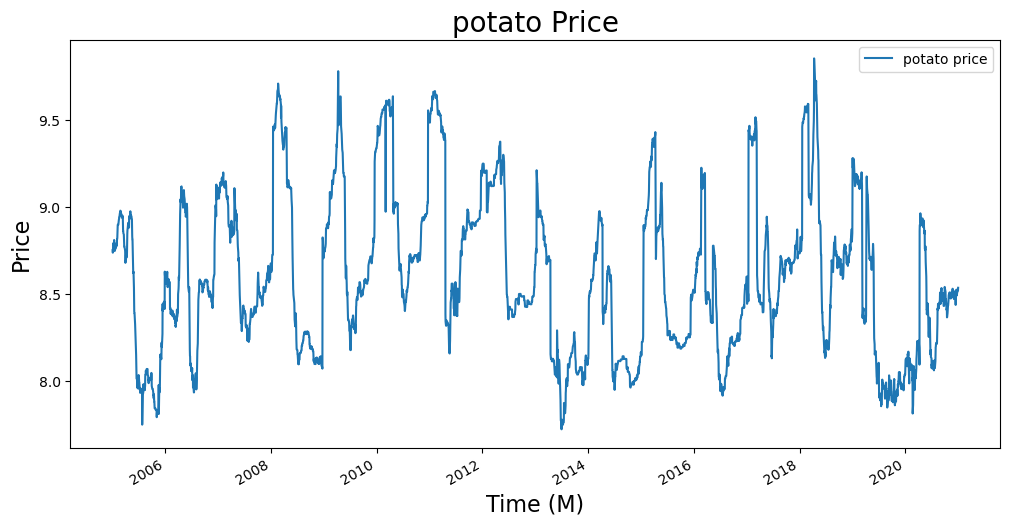

In [48]:
_fig_plot(df, 'ds', 'y')

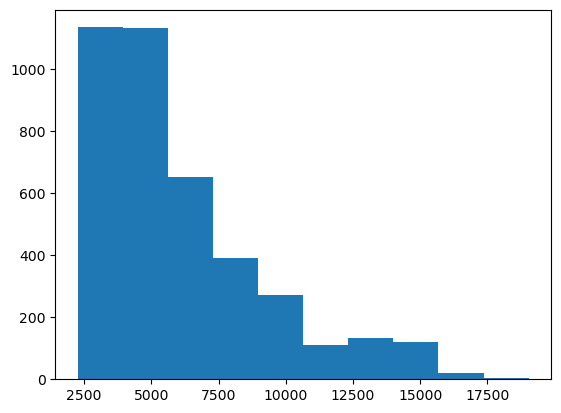

In [28]:
plt.hist(df.y)
plt.show()

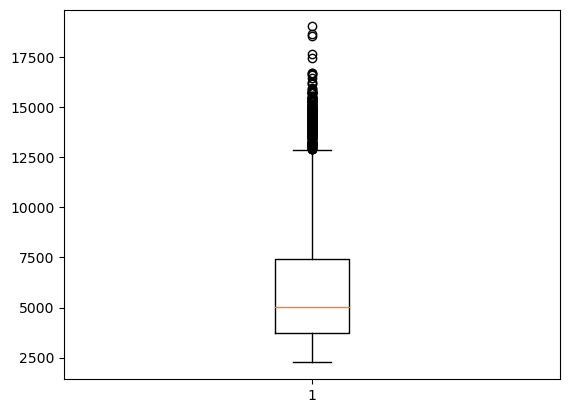

In [29]:
plt.boxplot(df.y)
plt.show()

## df['y'] = np.log(df['y'])

In [30]:
df_raw = df.copy()
df['y'] = np.log(df['y'])

## EDA

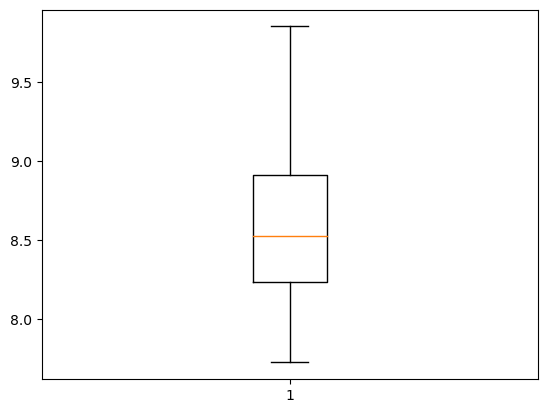

In [31]:
plt.boxplot(df.y.values)
plt.show()

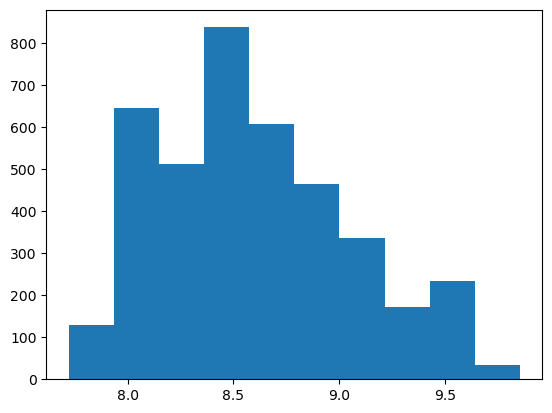

In [32]:
plt.hist(df.y)
plt.show()

## EDA - outlier

In [33]:
Q1=df.y.quantile(0.25)
Q3=df.y.quantile(0.75)
IQR = Q3-Q1
LT=Q1-1.5*IQR
HT= Q3+1.5*IQR
print(LT, HT)
df['outlier']=np.where(((df['y']<LT)|(df['y']>HT)),'yes','no')

7.211399328373522 9.930067321047735


In [34]:
df['outlier'].value_counts()

no    3970
Name: outlier, dtype: int64

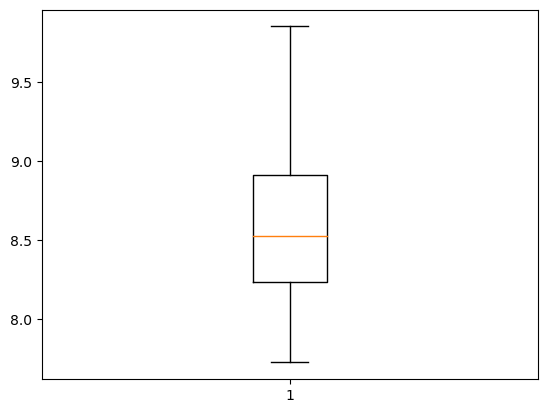

In [35]:
plt.boxplot(df[df.outlier=='no'].y)
plt.show()

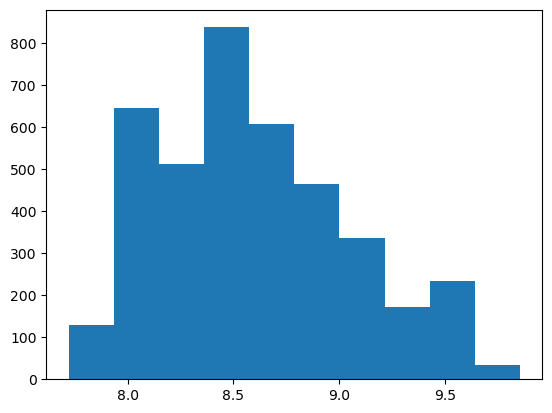

In [36]:
plt.hist(df[df.outlier=='no'].y)
plt.show()

# Modeling

## Prophet Sample

16:51:13 - cmdstanpy - INFO - Chain [1] start processing
16:51:14 - cmdstanpy - INFO - Chain [1] done processing


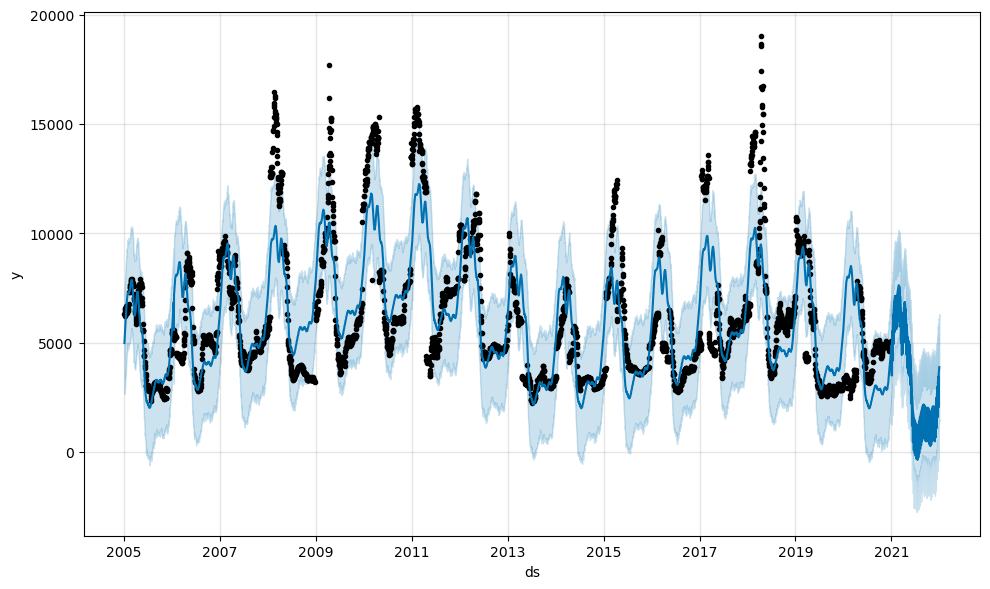

In [37]:
m = Prophet()
m.fit(df_raw)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)
plt.show()

In [38]:
# evaluation_model = cross_validation(m, initial='730 days', period='180 days', horizon = '30 days')
# evaluation_metrix = performance_metrics(evaluation_model)
# evaluation_metrix.head(5)

## data split

In [39]:
index_number = df.index[(df['ds'] == '2018-12-31')][0]
train = df.iloc[:index_number]
test = df.iloc[index_number:]
print('Training data, last date: ' + str(train.tail(1)['ds']) + ' ' + 'testing data, last date: ' + str(test.tail(1)['ds']))

Training data, last date: 3474   2018-12-28
Name: ds, dtype: datetime64[ns] testing data, last date: 3969   2020-12-31
Name: ds, dtype: datetime64[ns]


## Parameter - holiday

,ds,YM,MD,Product,y,KRW_USD_EXR,Annual_Call_Rate,item_PPI,item_CPI,Food_Price_Index,Cereals_Price_Index,DayAvg_Temperature,DayDiff_Temperature,DayAvg_RelativeHumidity,DaySum_Rainfall,DayAvg_WindSpeed,DaySum_Sunshine,Warning_Count,outlier
0,2005-01-03,200501,103,감자,8.751965,1013.0,3.33,71.15,69.162,65.4,60.5,4.500000,6.750000,47.750000,1.000000,3.750000,0.250000,0.0,no
1,2005-01-04,200501,104,감자,8.737663,1013.0,3.33,71.15,69.162,65.4,60.5,-2.250000,8.000000,36.250000,0.000000,3.000000,3.500000,0.0,no
2,2005-01-05,200501,105,감자,8.753376,1013.0,3.33,71.15,69.162,65.4,60.5,-3.500000,11.500000,44.750000,0.000000,0.500000,4.250000,0.0,no
3,2005-01-06,200501,106,감자,8.766761,1013.0,3.33,71.15,69.162,65.4,60.5,1.500000,7.000000,45.250000,1.500000,1.500000,2.250000,0.0,no
4,2005-01-07,200501,107,감자,8.791997,1013.0,3.33,71.15,69.162,65.4,60.5,0.250000,9.250000,38.750000,0.000000,3.000000,4.000000,0.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3470,2018-12-21,201812,1221,감자,8.816367,1118.1,1.52,140.36,118.879,92.2,101.1,4.250000,10.500000,71.750000,0.000000,0.500000,2.250000,0.0,no
3471,2018-12-24,201812,1224,감자,8.834453,1118.1,1.52,140.36,118.879,92.2,101.1,-1.250000,9.000000,60.250000,0.000000,1.000000,4.500000,0.5,no
3472,2018-12-26,201812,1226,감자,8.868215,1118.1,1.52,140.36,118.879,92.2,101.1,1.750000,7.000000,54.250000,0.000000,1.750000,3.500000,0.5,no
3473,2018-12-27,201812,1227,감자,8.873488,1118.1,1.52,140.36,118.879,92.2,101.1,-6.500000,7.000000,36.000000,0.000000,2.666667,4.666667,1.0,no


In [40]:
# 휴일 생성
import holidays

# 필요한 날짜만큼 생성
date_list = pd.date_range(f'{train[0]}-01-01', f'{test[1]}-12-31')

# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday = pd.DataFrame(columns=['ds','holiday'])
holiday['ds'] = sorted(date_list)
holiday['holiday'] = holiday.ds.apply(lambda x: kr_holidays.get(x) if x in kr_holidays else 'non-holiday')
holiday.head()

KeyError: 0

## Parameter Search - Grid

In [ ]:
if params_search == True:
    from sklearn.model_selection import ParameterGrid
    params_grid = {
                'seasonality_mode':('multiplicative','additive'),
                'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
                'n_changepoints' : [100,150,200]
                }
    grid = ParameterGrid(params_grid)
    cnt = 0
    for p in grid:
        cnt = cnt+1

    print('Total Possible Models',cnt)

In [ ]:
if params_search == True:
    model_parameters = pd.DataFrame(columns = ['MAE','Parameters'])
    for p in grid:
        LOL = pd.DataFrame()
        print(p)
    #    random.seed(0)
        train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                            holidays_prior_scale = p['holidays_prior_scale'],
                            n_changepoints = p['n_changepoints'],
                            seasonality_mode = p['seasonality_mode'],
                            
                            daily_seasonality = True,
                            yearly_seasonality = True,
                            holidays=holiday, 
                            interval_width=0.95)
        
        train_model.fit(train)
        future = train_model.make_future_dataframe(periods=366, freq=freq,include_history = False)
        train_forecast = train_model.predict(future)
        LOL=train_forecast[['ds','yhat']]
        y_true= test['y'].values
        y_pred = LOL['yhat'][:len(y_true)].values
        mae = mean_absolute_error(y_true, y_pred)
        print('Mean Absolute Error: %.3f' % mae)
        model_parameters = model_parameters.append({'MAE':mae,'Parameters':p},ignore_index=True)

## Parameters

In [ ]:
if params_search == True:
    parameters = model_parameters.sort_values(by=['MAE'])
    parameters = parameters.reset_index(drop=True)
    display(parameters.head())

    params = dict(parameters['Parameters'][0])
else:
    params = {'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100,'seasonality_mode': 'additive'}

In [ ]:
train = train.drop(columns=['YM', 'MD', 'Product', 'KRW_USD_EXR', 'Annual_Call_Rate',
       'item_PPI', 'item_CPI', 'Food_Price_Index', 'Cereals_Price_Index', 'outlier'
       ])
train['Warning_Count'] = np.exp(train['Warning_Count'])
train.columns

In [ ]:
df = pd.merge(dates, df, how='outer', on='ds')
df

In [ ]:
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= params["changepoint_prior_scale"],
                      holidays_prior_scale = params["holidays_prior_scale"],
                      n_changepoints = params["n_changepoints"],
                      seasonality_mode = params["seasonality_mode"],
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.fit(train)

In [ ]:
future = final_model.make_future_dataframe(periods=366, freq=freq)
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

### 주석풀지마시오

In [ ]:
# figure = plt.figure(figsize=(12, 6), dpi=80)
# plt.plot(y_true, label='Actual')
# plt.plot(y_pred, label='Predicted')
# plt.xlabel('Time ->>>', fontsize = 18)
# plt.ylabel('$ Price ->>>', fontsize = 18)
# plt.title('Stock price prediction with Fb Prophet', fontsize = 26)
# plt.legend()
# plt.show()

In [ ]:
df['y']=np.exp(df['y'])
forecast['yhat']=np.exp(forecast['yhat'])

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df['ds'], df['y'], label='real')
plt.plot(forecast['ds'], forecast['yhat'], label='forecast')
plt.grid()
plt.legend()
plt.show()

In [ ]:
con = pd.concat([df, forecast], axis=1)
con = con.dropna(axis=0)
df = con[df.columns]
forecast1 = con[forecast.columns]

In [ ]:
y_true= df['y'].values
y_pred = forecast1['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('Mean Absolute Error: %.3f' % mae)

In [ ]:
evaluation_model = cross_validation(final_model, initial='720 days', period='180 days', horizon = '30 days')
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('mae').head(5)

In [ ]:
con

In [ ]:
df_temp = pd.DataFrame()
df_temp["true"] = y_true
df_temp["pred"] = y_pred

# report file
report_file_name = f"""{model_name}_{Product}_\{freq {freq}; test. {test}; MAE. {mae:0.4f};\}.csv"""
reportinfo_file_name = f"{report_file_name}.txt"

feature = train.columns
f = open(reportinfo_file_name,'w')
f.write(f"model_name : {model_name}")
f.write(f"Product: {Product}")
f.write(f"freq : {freq}")
f.write(f"test : {test}")
f.write(f"train : {train}")
f.write(f"feature : {feature}")
f.write(f"params : {params}")
f.close()

df_temp.to_csv(f"{data_path}prophet_garlic_{mae:0.4f}.csv")
print()
df_temp.head()